# Experiments on Synthetic Data
For the details of the experimental setup and results please see Section 5.1 of the main text.

In [1]:
# IMPORTS

# BASICS
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random
from math import exp, sqrt, log, tanh
from copy import deepcopy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# STYLE (optional)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"


# SCIKIT-LEARN
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# ADAPTIVE SAFEPREDICT 

class SafePredict:
    def __init__(self,  eps = 0.1, w0 = 0.5, alpha = 0, beta = 1, horizon = 1):
        # Initialize
        self.eps = eps        # Target error rate
        self.w0 = w0          # Initial weight of Dummy (i.e. 1- w_P)
        self.w = [w0, 1-w0]
        self.wPs = (1-w0)*w0
        self.alpha = alpha    # Adaptivity parameter: w_P >= alpha (default value 0)
        self.beta = beta      # Adaptivity parameter: w_P <= beta (default value 1)
        self.T = horizon      # Time horizon
        self.C = sqrt(-log(w0) - (self.T-1)*log(1-self.alpha)) / (1-self.eps) 
        self.k = 1 
        self.eta = self.C / 2**(self.k/2)


      
        
    def update(self, lP):
        # Update the weights, one data point at a time
        
        # Update the weights
        if self.wPs < 2**self.k:
            self.w[0] = self.w[0]*exp(-self.eta * self.eps); self.w[1] = self.w[1]*exp(-self.eta * lP); W = sum(self.w)
            self.w[0] /= W; self.w[1] /= W
        else:
            self.w[0] = self.w0; self.w[1] = 1-self.w0
            self.k += 1
            self.eta = self.eta / sqrt(2)
            self.wPs = (1-self.w0)*self.w0
        
        _w_1 = self.w[1]
        # Mix the weights
        self.w[0] = self.w[0]*(self.beta-self.alpha) + 1 - self.beta 
        self.w[1] = self.w[1]*(self.beta-self.alpha) + self.alpha
        
        
        # Update the learning rate 
        self.wPs += self.w[1]*self.w[0]
        
        # Return the prediction probability
        return _w_1

In [3]:
# GENERATION OF SYNTHETIC DATA

epsilon = 0.05
w0 = 0.5
HORIZON = 50000
CHANGE_POINTS = 10
LOW_NOISE = epsilon*0.8
HIGH_NOISE = epsilon*2

PP = [LOW_NOISE + (HIGH_NOISE-LOW_NOISE) * ((i//(HORIZON/(CHANGE_POINTS+1)))%2) for i in range(HORIZON)]
LP = [random()<PP[i] for i in range(len(PP))] # The simulated loss sequence for the base predictor

In [4]:
# INITIALIZE THE SAFEPREDICT INSTANCES WITH INCREASING VALUES OF alpha

r1 = SafePredict(eps = epsilon, w0 = w0, alpha =0, horizon = HORIZON)
Wp1 = []


r2 = SafePredict(eps = epsilon, w0 = w0, alpha = 1/HORIZON, horizon = HORIZON)
Wp2 = []


r3 = SafePredict(eps = epsilon, w0 = w0, alpha = 5/HORIZON, horizon = HORIZON)
Wp3 = []
        
    
r4 = SafePredict(eps = epsilon, w0 = w0, alpha = 10/HORIZON, horizon = HORIZON)
Wp4 = []
        

# RUN THE EXPERIMENT
for lP in tqdm(LP):
    Wp1.append(r1.update(lP))
    Wp2.append(r2.update(lP))
    Wp3.append(r3.update(lP))
    Wp4.append(r4.update(lP))
# REPORT THE FINAL ERROR RATES AND EFFICIENCIES
dot_prod = lambda v1, v2: np.sum([i*j for i,j in zip(v1, v2) ] )/np.sum(v1)
print("Error Rates:",'\t', dot_prod(Wp1, LP),'\t',  dot_prod(Wp2, LP),'\t', dot_prod(Wp3, LP), '\t', dot_prod(Wp4, LP) )
print("Efficiencies:",'\t', np.sum(Wp1)/len(LP),'\t', np.sum(Wp2)/len(LP),'\t', np.sum(Wp3)/len(LP),'\t', np.sum(Wp4)/len(LP) )

100%|██████████| 50000/50000 [00:00<00:00, 70923.38it/s]

Error Rates: 	 0.048087210352899645 	 0.054967203101809824 	 0.05358563686033746 	 0.05276777377581875
Efficiencies: 	 0.06187805146767577 	 0.16493946283994923 	 0.3685744973690981 	 0.44767075428607167


Text(0.5, 0, 'Time')

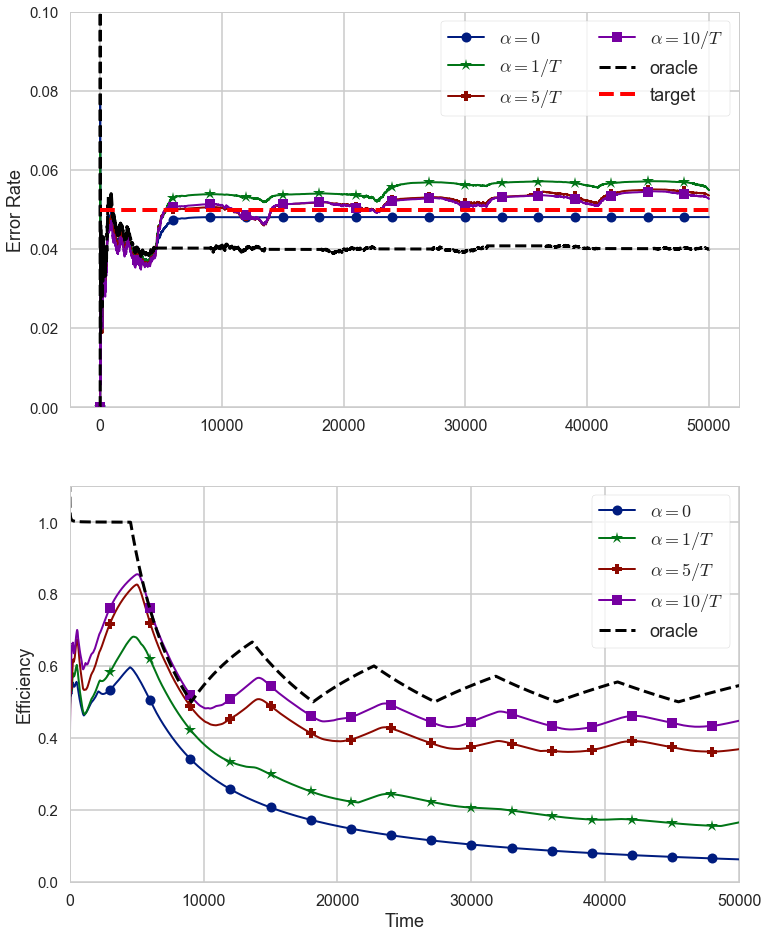

In [5]:
# ERROR AND EFFICIENCY PLOTS 
WW  = 12; HH = 16; ll = 2; ms = 10; me = 3000
# width, heigh, line_width, marker_size, mark_every

plt.figure(figsize=(WW,HH))

ax = plt.subplot(2,1,1)
plt.plot(np.cumsum([Wp1[i]*LP[i] for i in range(HORIZON)])/np.cumsum(Wp1), label = r'$ \alpha  = 0$', linestyle='-', linewidth=ll, marker = 'o', markevery=me, markersize = ms)
plt.plot(np.cumsum([Wp2[i]*LP[i] for i in range(HORIZON)])/np.cumsum(Wp2), label = r'$ \alpha  = 1/T$', linestyle='-', linewidth=ll, marker = '*', markevery=me, markersize = ms+2)
plt.plot(np.cumsum([Wp3[i]*LP[i] for i in range(HORIZON)])/np.cumsum(Wp3), label = r'$ \alpha  = 5/T$',  linestyle='-', linewidth=ll, marker = 'P', markevery=me, markersize = ms)
plt.plot(np.cumsum([Wp4[i]*LP[i] for i in range(HORIZON)])/np.cumsum(Wp4), label = r'$ \alpha  = 10/T$',  linestyle='-', linewidth=ll, marker = 's', markevery=me, markersize = ms)
plt.plot(np.cumsum([LP[i]*(PP[i] <= epsilon) for i in range(HORIZON)])/np.cumsum([PP[i] <= epsilon for i in range(HORIZON)]),'k', label = "oracle",  linestyle='--', linewidth=ll*1.5 )#, marker = 'd', markevery=me, markersize = ms)
plt.plot([0, HORIZON-1],[epsilon, epsilon],'r', label = "target",  linestyle='--', linewidth=ll*2 )
plt.ylabel("Error Rate", fontsize= 18, x = -0.05)
plt.yticks(fontsize = 15)
plt.ylim([0, 2*epsilon])
lg = ax.legend(loc='best', ncol = 2, fontsize =18)
lg.draw_frame(True)


ax = plt.subplot(2,1,2)
plt.plot(np.cumsum(Wp1)/np.arange(HORIZON), label = r'$ \alpha  = 0$', linestyle='-', linewidth=ll, marker = 'o', markevery=me, markersize = ms)
plt.plot(np.cumsum(Wp2)/np.arange(HORIZON), label = r'$ \alpha  = 1/T$', linestyle='-', linewidth=ll, marker = '*', markevery=me, markersize = ms+2)
plt.plot(np.cumsum(Wp3)/np.arange(HORIZON), label = r'$ \alpha  = 5/T$',  linestyle='-', linewidth=ll, marker = 'P', markevery=me, markersize = ms)
plt.plot(np.cumsum(Wp4)/np.arange(HORIZON), label = r'$ \alpha  = 10/T$',  linestyle='-', linewidth=ll, marker = 's', markevery=me, markersize = ms)
plt.plot(np.cumsum([p <= epsilon for p in PP])/np.arange(HORIZON),'k', label = "oracle",  linestyle='--', linewidth=ll*1.5 )#, marker = 'd', markevery=me, markersize = ms)
plt.ylabel("Efficiency", fontsize= 18, x = -0.05)
plt.ylim([0, 1.1])
plt.xlim([0, 50000])
plt.yticks(fontsize = 15)
lg = ax.legend(loc='best', ncol = 1, fontsize =18)
lg.draw_frame(True)
plt.xlabel("Time", fontsize = 18)